## Setup

In [1]:
%run setup.ipynb
import peakfit
rcParams['figure.dpi'] = 120

## H12

In [2]:
df_h12 = phase1_selection.hstats_windowed
df_h12.head(10)

AOM       BFM       BFS       CMS  GAS       GNS  \
chrom start  stop                                                       
2L    1      20000   NaN       NaN       NaN       NaN  NaN       NaN   
      20001  40000   NaN       NaN       NaN       NaN  NaN       NaN   
      40001  60000   NaN       NaN       NaN       NaN  NaN       NaN   
      60001  80000   NaN       NaN       NaN       NaN  NaN       NaN   
      80001  100000  NaN       NaN       NaN       NaN  NaN       NaN   
      100001 120000  NaN       NaN       NaN       NaN  NaN       NaN   
      120001 140000  NaN       NaN       NaN       NaN  NaN       NaN   
      140001 160000  NaN       NaN       NaN       NaN  NaN       NaN   
      160001 180000  NaN  0.431632  0.769395  0.093488  NaN  0.817898   
      180001 200000  NaN  0.481516  0.769242  0.106883  NaN  0.846514   

                          GWA       UGS  
chrom start  stop                        
2L    1      20000        NaN       NaN  
      20001  40000        NaN       NaN  
      40001  60000        NaN       NaN  
      60001  80000        NaN       NaN  
      80001  100000       NaN       NaN  
      100001 120000       NaN       NaN  
      120001 140000       NaN       NaN  
      140001 160000       NaN       NaN  
      160001 180000  0.049386  0.706240  
      180001 200000  0.049386  0.706146

In [3]:
# these are the regression model parameters
amplitude = lmfit.Parameter(value=.5, vary=True, min=0)
decay = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # exponential
sigma = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # gaussian
skew = lmfit.Parameter(value=0, vary=True, min=-1, max=1)
baseline = lmfit.Parameter(value=.03, vary=True, min=0, max=1)
ceiling = lmfit.Parameter(value=1, vary=False)
floor = lmfit.Parameter(value=0, vary=False)
null = lmfit.Parameter(value=.05, vary=True, min=0, max=1)


# this determines how the full boundaries of the peak are found after the regression model has been fitted
peak_limit_frc = .2


h12_skewed_exp_fitter = peakfit.SkewedExponentialPeakFitter(
    amplitude=amplitude,
    decay=decay,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)


h12_skewed_gauss_fitter = peakfit.SkewedGaussianPeakFitter(
    amplitude=amplitude,
    sigma=sigma,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)

In [4]:
def plot_h12_peak_fit(pop, chromosome, center, flank, fitter, ax=None, 
                      xlabel='Genetic distance (cM)', ylabel='H12'):

    # This function handles concatenating data from multiple chromosome arms.
    # N.B., ignore percentiles for now, these are percentiles over windowed values.
    if chromosome == '2':
        seqid = '2R', '2L'
    elif chromosome == '3':
        seqid = '3R', '3L'
    else:
        seqid = chromosome
    starts, ends, values, percentiles = peakfit.extract_windowed_values(
        df_h12, seqid=seqid, genome=genome, values_col=pop, seqid_col='chrom',
        starts_col='start', ends_col='stop'
    )

    # setup X and Y coordinates
    x = ((starts + ends) / 2).astype(int)
    # this converts physical to genetic distance, needed if center and flank are also
    # given in terms of genetic distance
    x = gmap[chromosome].take(x - 1)
    y = values
    
    # fit the model
    fit = fitter.fit(x, y, center, flank)
    
    # plot
    if ax is None:
        fig, ax = plt.subplots()
    plot_opts = dict(marker='o', linestyle=' ', markersize=3, mfc='none', color='k', mew=.5)
    # plot the best fit line
    ax.plot(fit.xx, fit.best_fit, lw=.5, linestyle='--', color='k')
    # plot the data
    ax.plot(fit.xx, fit.yy, **plot_opts)
    # annotate
    ax.text(.98, .98, r'$\Delta_{i}$ : %.1f' % fit.delta_aic, transform=ax.transAxes, ha='right', va='top')
    # tidy
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # TODO add secondary yticklabels to right-hand Y axis with percentiles


In [5]:
# gmap is a genetic map of sorts, it's defined in agam-selection-atlas/scripts/setup.py
cyp6p_center = gmap['2'][(28480576 + 28505816)//2]
vgsc_center = gmap['2'][len(genome['2R']) + (2358158 + 2431617)//2]
ace1_center = gmap['2'][(3484107 + 3495790)//2]
gste_center = gmap['3'][(28591663 + 28602280)//2]
cyp9k1_center = gmap['X'][(15240572 + 15242864)//2]


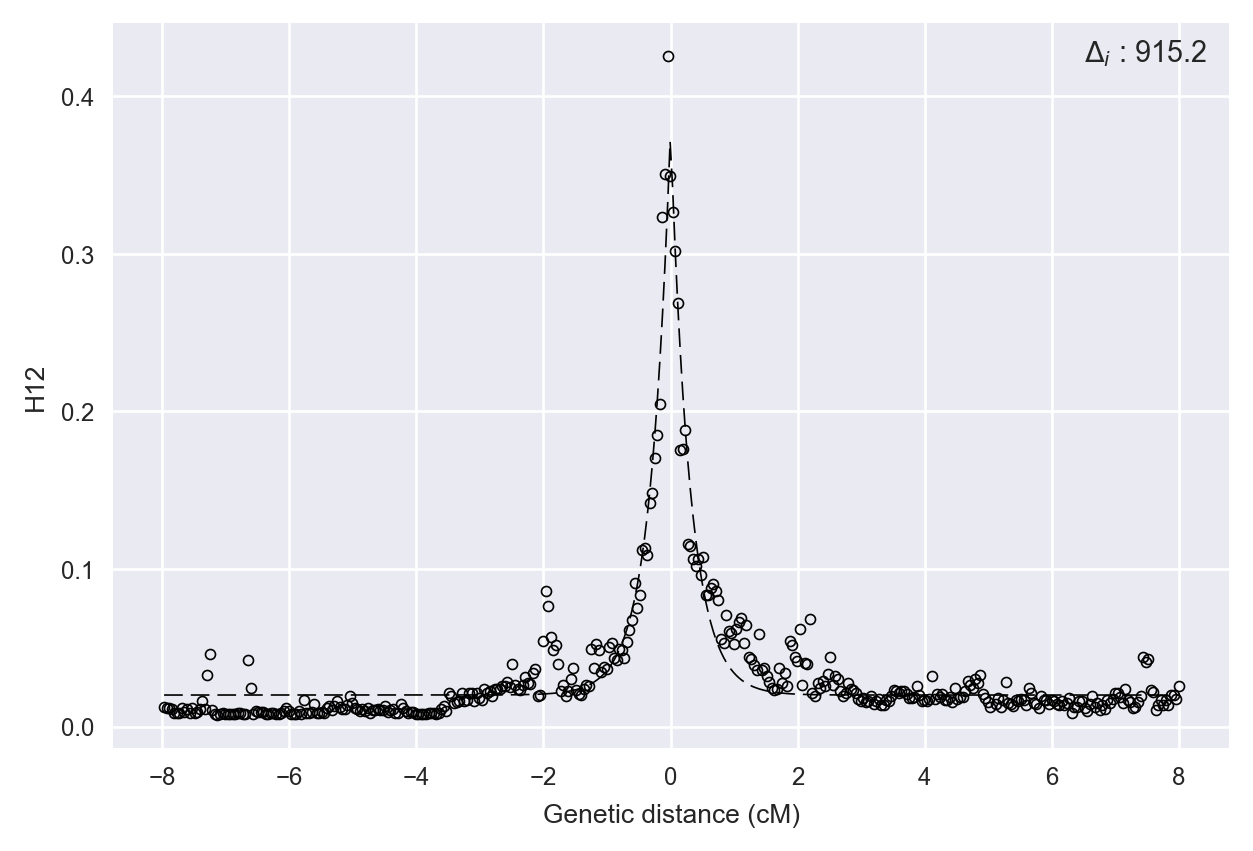

In [6]:
plot_h12_peak_fit(pop='BFS', chromosome='2', center=cyp6p_center, flank=8, fitter=h12_skewed_exp_fitter)

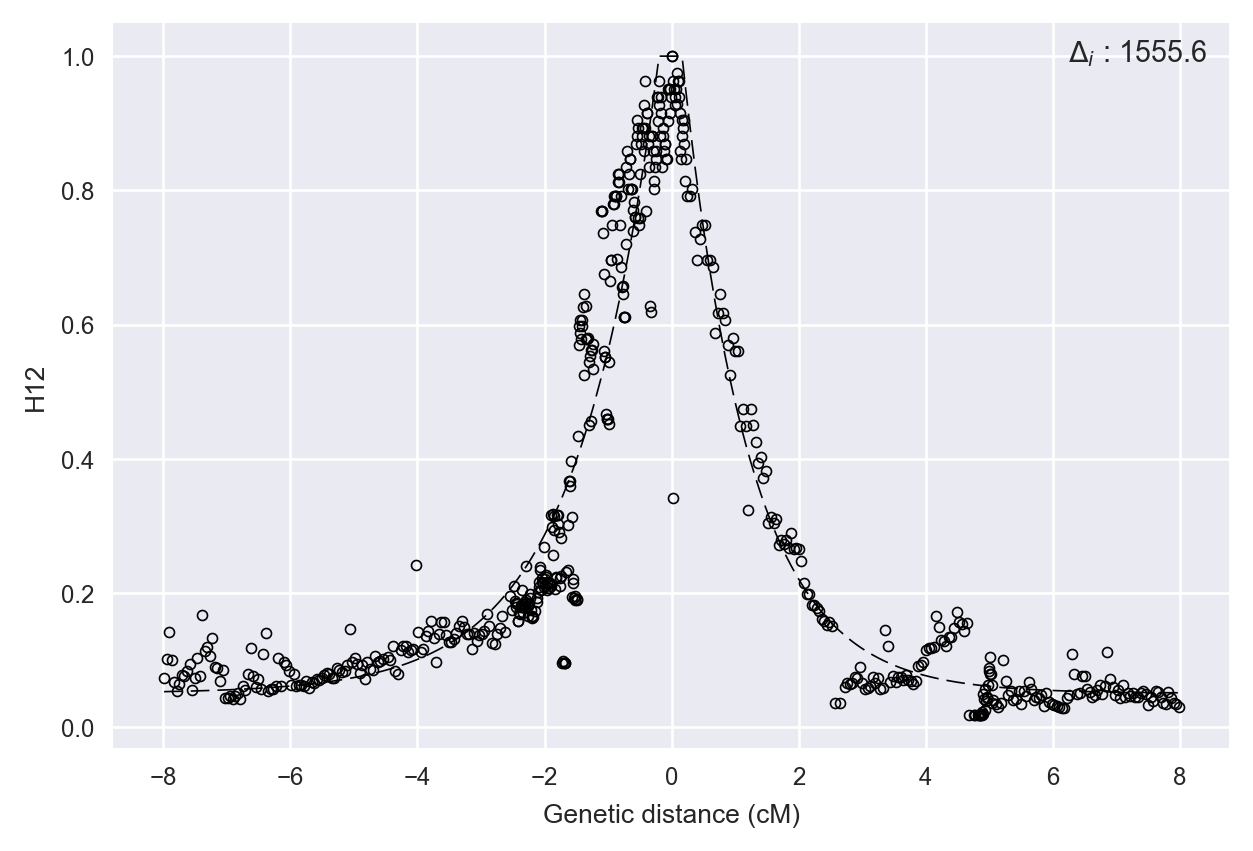

In [7]:
plot_h12_peak_fit(pop='BFS', chromosome='2', center=vgsc_center, flank=8, fitter=h12_skewed_exp_fitter)

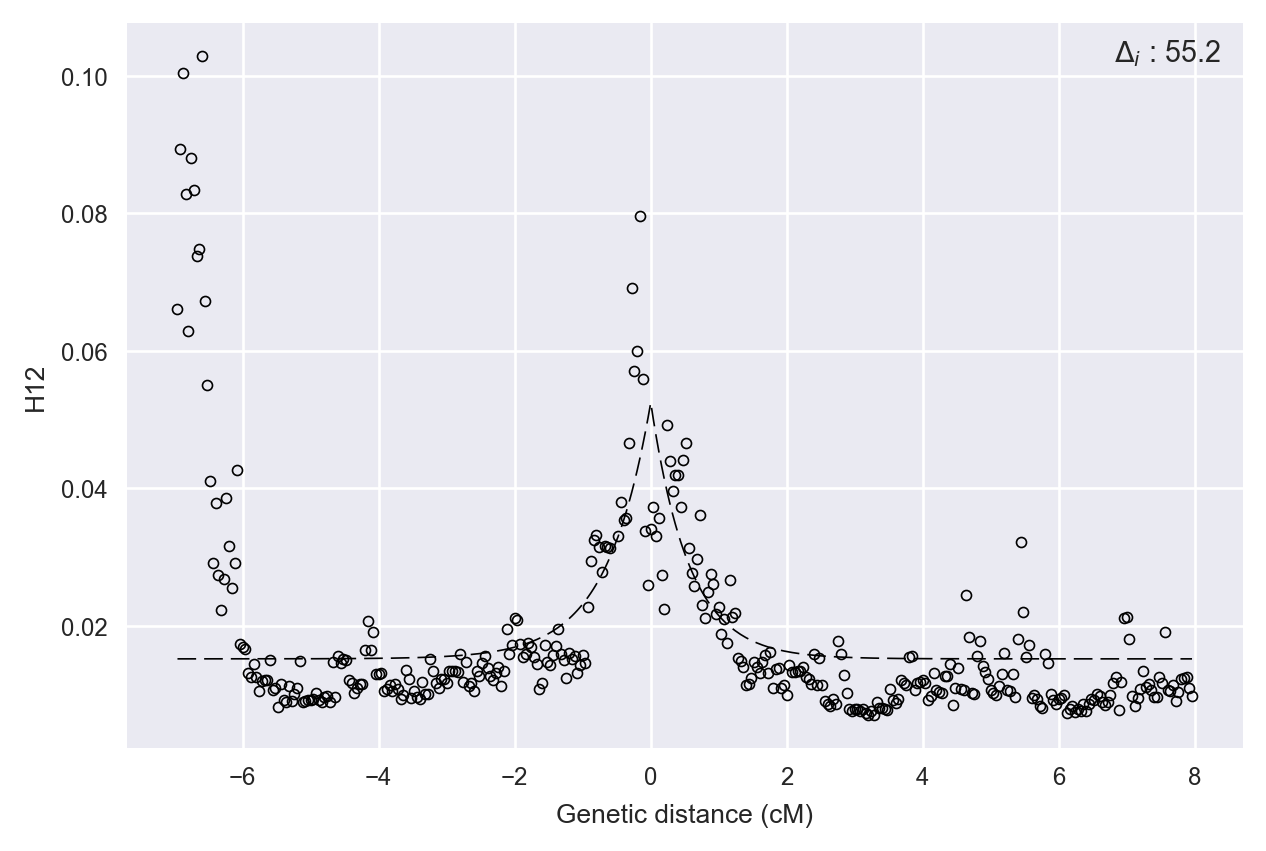

In [8]:
plot_h12_peak_fit(pop='BFS', chromosome='2', center=ace1_center, flank=8, fitter=h12_skewed_exp_fitter)

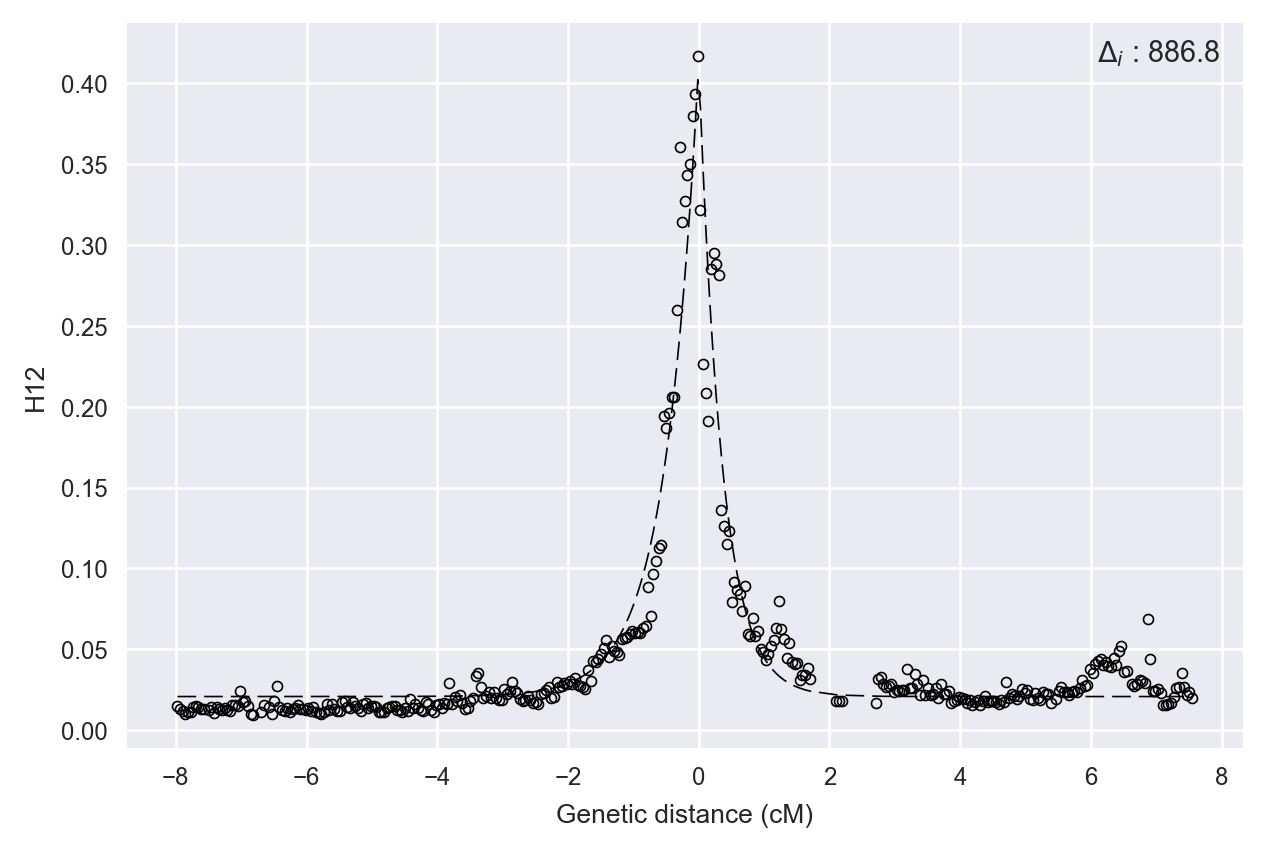

In [9]:
plot_h12_peak_fit(pop='BFS', chromosome='3', center=gste_center, flank=8, fitter=h12_skewed_exp_fitter)

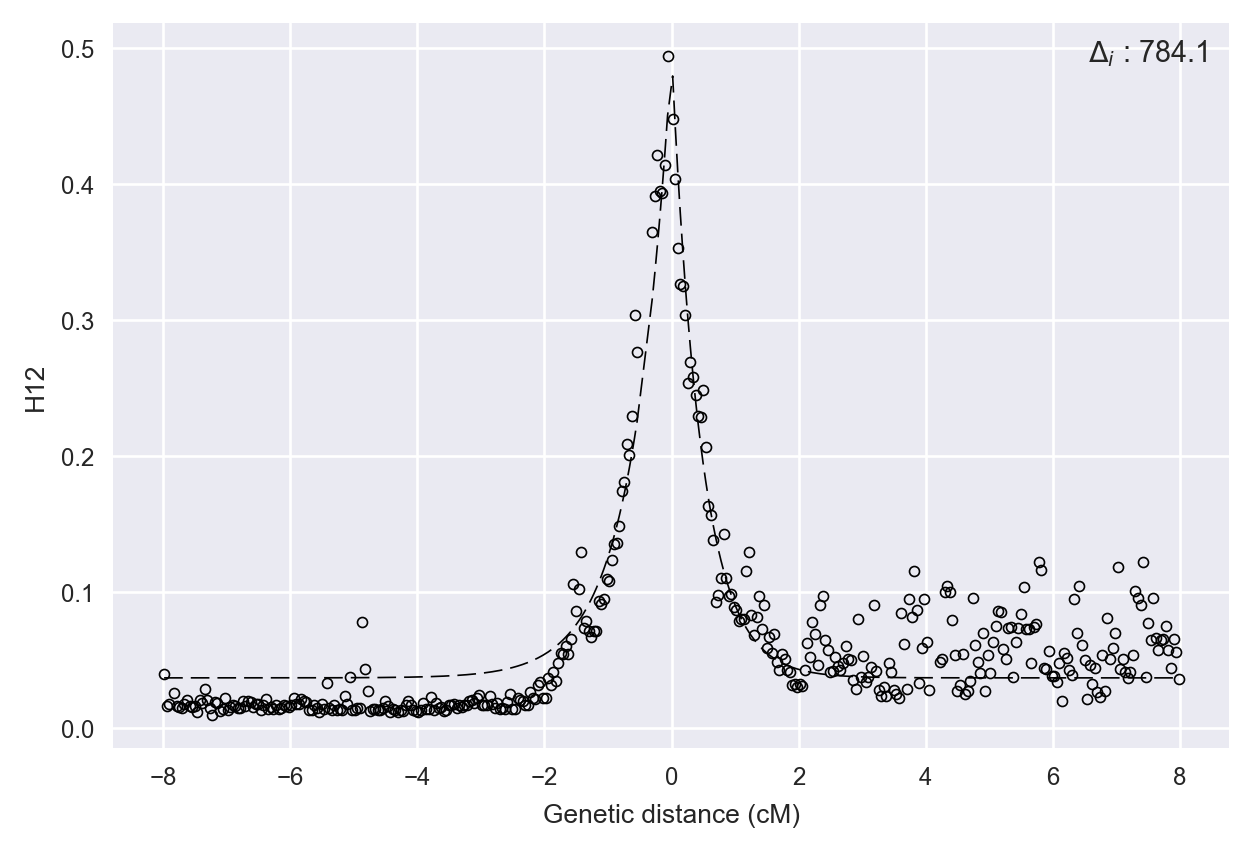

In [10]:
plot_h12_peak_fit(pop='BFS', chromosome='X', center=cyp9k1_center, flank=8, fitter=h12_skewed_exp_fitter)

## IHS

In [11]:
ihs_raw = phase1_selection.ihs_raw
ihs_raw

Group(/, 5)
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [12]:
@functools.lru_cache(maxsize=None)
def build_ihs_dataframe(pop, seqid, window_size):
    
    if seqid is None:
        df = pd.concat([build_ihs_dataframe(pop, seqid=seqid, window_size=window_size) for seqid in seqids])
        return df

    # extract raw values for windowing
    grp = ihs_raw[seqid][pop]
    pos = grp['POS'][:]
    values = np.abs(grp['iHS_gw_std'][:])
    nomiss = ~np.isnan(values)
    pos_nomiss = pos[nomiss]
    values_nomiss = values[nomiss]
    
    # construct moving windows
    starts_col = allel.moving_statistic(pos_nomiss, statistic=lambda v: v[0], size=window_size)
    starts_col[0] = 1  # fix to start of sequence
    ends_col = np.append(starts_col[1:] - 1, [len(genome[seqid])])
    
    # summarise values in windows
    values_col = allel.moving_statistic(values_nomiss, statistic=np.max, size=window_size)
    
    # seqid column
    seqid_col = np.array([seqid] * len(starts_col))
    
    # build dataframe
    df = pd.DataFrame.from_items([
        ('seqid', seqid_col), 
        ('start', starts_col), 
        ('end', ends_col), 
        ('value', values_col)
    ])
    return df


In [13]:
# these are the regression model parameters
amplitude = lmfit.Parameter(value=3, vary=True, min=0)
decay = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # exponential
sigma = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # gaussian
skew = lmfit.Parameter(value=0, vary=True, min=-1, max=1)
baseline = lmfit.Parameter(value=1, vary=True, min=0, max=100)
ceiling = lmfit.Parameter(value=100, vary=False)
floor = lmfit.Parameter(value=0, vary=False)
null = lmfit.Parameter(value=1, vary=True, min=0, max=100)


# this determines how the full boundaries of the peak are found after the regression model has been fitted
peak_limit_frc = .2


ihs_skewed_exp_fitter = peakfit.SkewedExponentialPeakFitter(
    amplitude=amplitude,
    decay=decay,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)


ihs_skewed_gauss_fitter = peakfit.SkewedGaussianPeakFitter(
    amplitude=amplitude,
    sigma=sigma,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)

In [14]:
def plot_ihs_peak_fit(pop, chromosome, center, flank, fitter, ax=None, 
                      xlabel='Genetic distance (cM)', ylabel='IHS', window_size=200):

    df_ihs = build_ihs_dataframe(pop, seqid=None, window_size=window_size)
    
    # This function handles concatenating data from multiple chromosome arms.
    # N.B., ignore percentiles for now, these are percentiles over windowed values.
    if chromosome == '2':
        seqid = '2R', '2L'
    elif chromosome == '3':
        seqid = '3R', '3L'
    else:
        seqid = chromosome
    starts, ends, values, percentiles = peakfit.extract_windowed_values(
        df_ihs, seqid=seqid, genome=genome, values_col='value', seqid_col='seqid',
        starts_col='start', ends_col='end'
    )

    # setup X and Y coordinates
    x = ((starts + ends) / 2).astype(int)
    # this converts physical to genetic distance, needed if center and flank are also
    # given in terms of genetic distance
    x = gmap[chromosome].take(x - 1)
    y = values
    
    # fit the model
    fit = fitter.fit(x, y, center, flank)
    
    # plot
    if ax is None:
        fig, ax = plt.subplots()
    plot_opts = dict(marker='o', linestyle=' ', markersize=3, mfc='none', color='k', mew=.5)
    # plot the best fit line
    ax.plot(fit.xx, fit.best_fit, lw=.5, linestyle='--', color='k')
    # plot the data
    ax.plot(fit.xx, fit.yy, **plot_opts)
    # annotate
    ax.text(.98, .98, r'$\Delta_{i}$ : %.1f' % fit.delta_aic, transform=ax.transAxes, ha='right', va='top')
    # tidy
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # TODO add secondary yticklabels to right-hand Y axis with percentiles


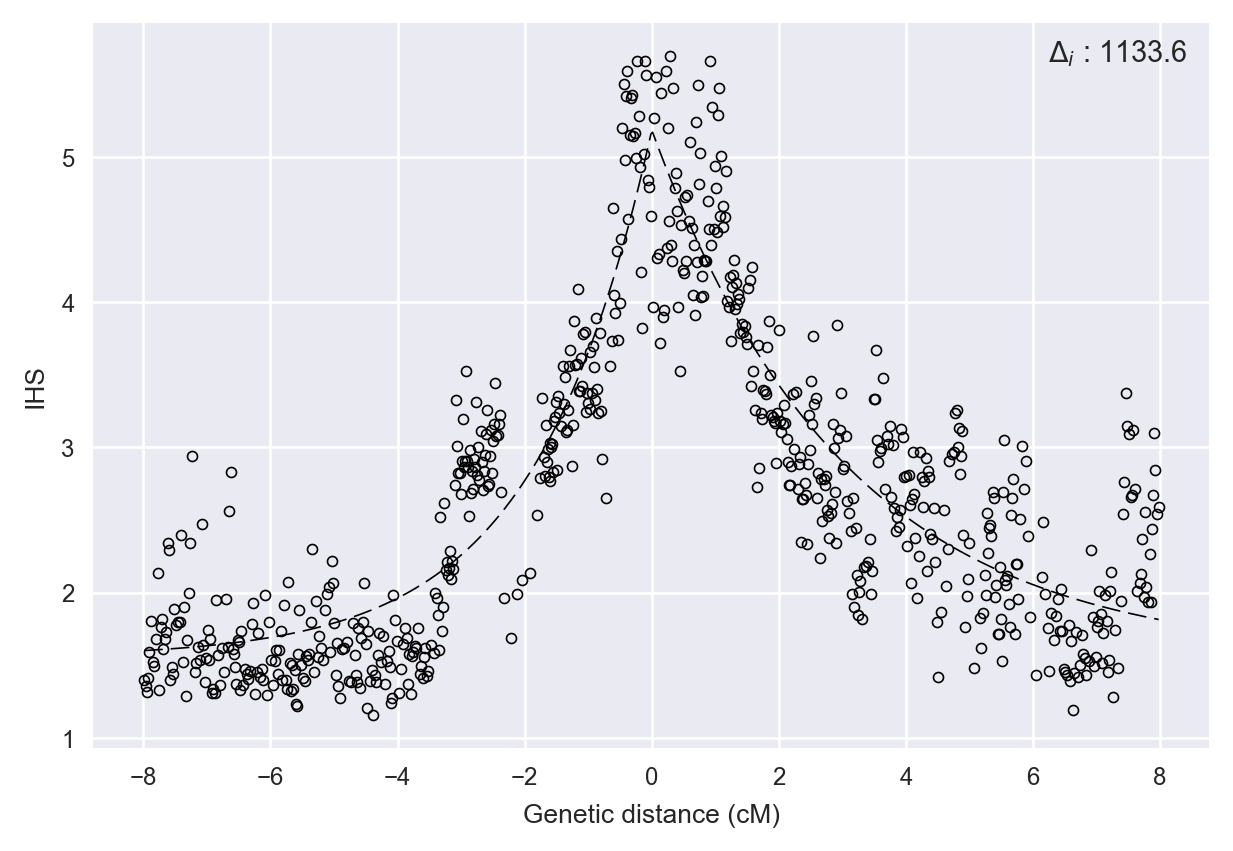

In [15]:
plot_ihs_peak_fit(pop='BFS', chromosome='2', center=cyp6p_center, flank=8, fitter=ihs_skewed_exp_fitter)

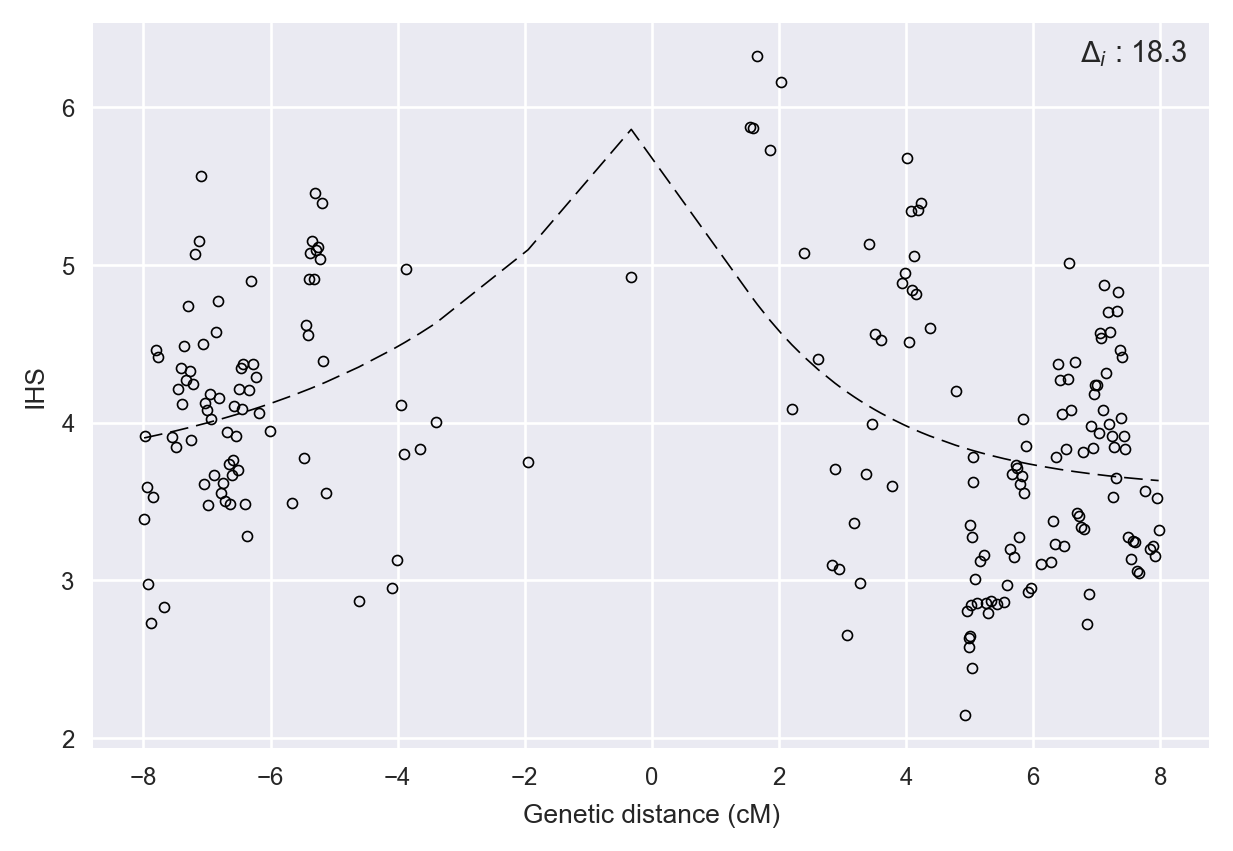

In [16]:
plot_ihs_peak_fit(pop='BFS', chromosome='2', center=vgsc_center, flank=8, fitter=ihs_skewed_exp_fitter)

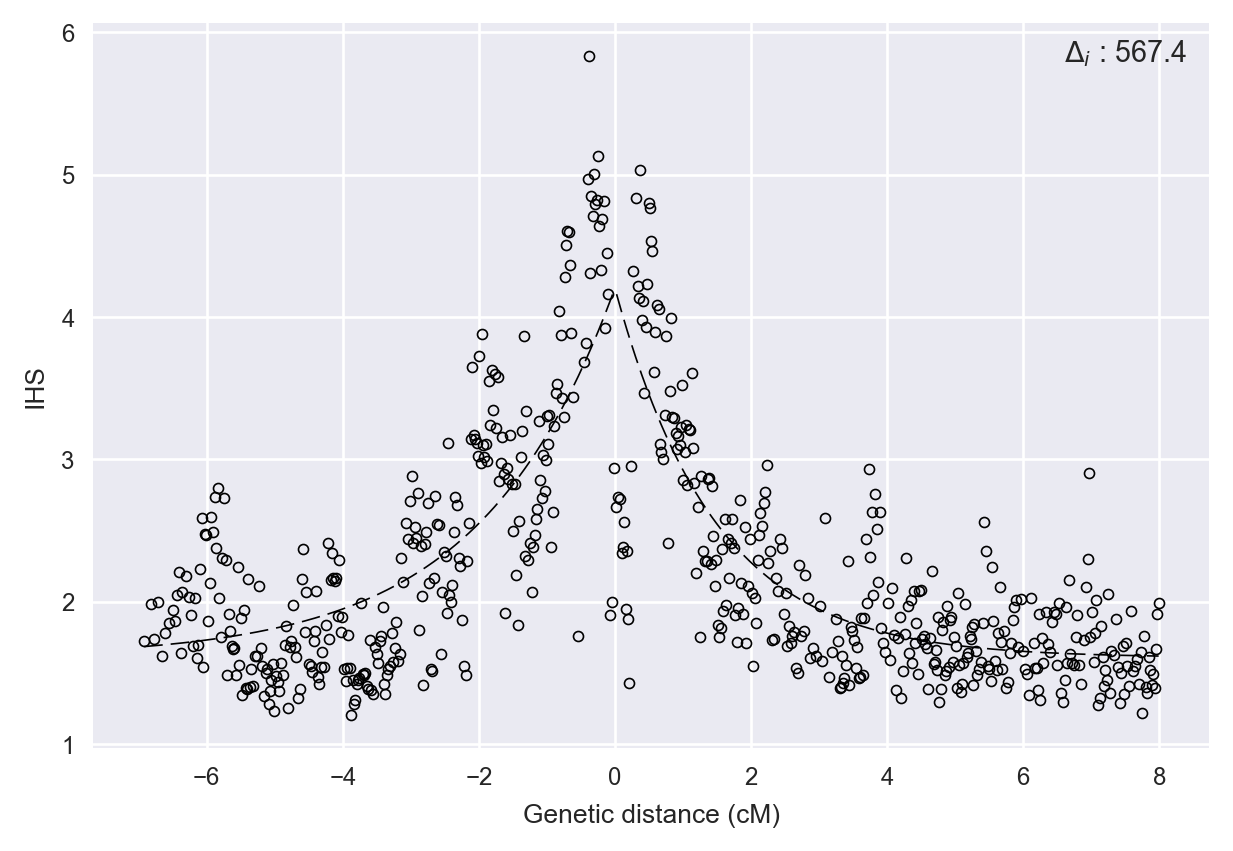

In [17]:
plot_ihs_peak_fit(pop='BFS', chromosome='2', center=ace1_center, flank=8, fitter=ihs_skewed_exp_fitter)

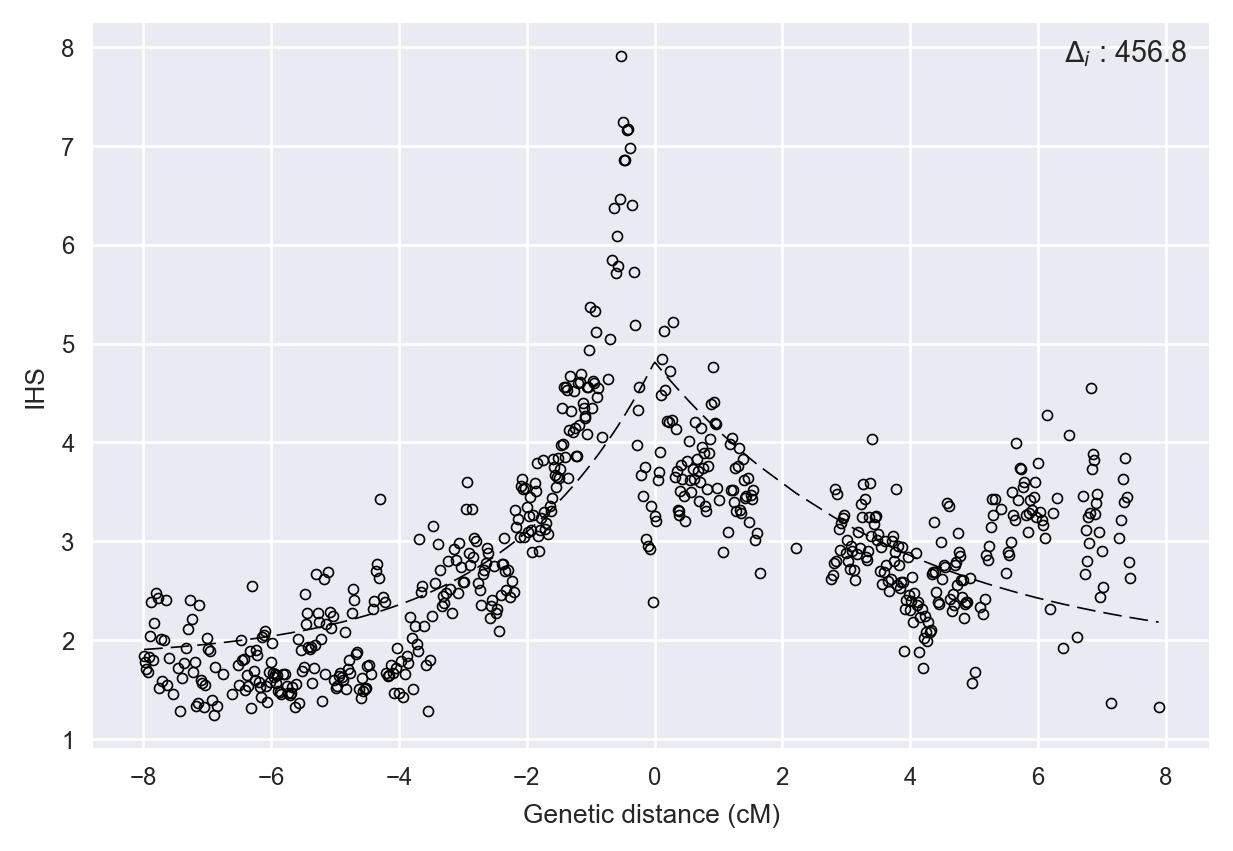

In [18]:
plot_ihs_peak_fit(pop='BFS', chromosome='3', center=gste_center, flank=8, fitter=ihs_skewed_exp_fitter)

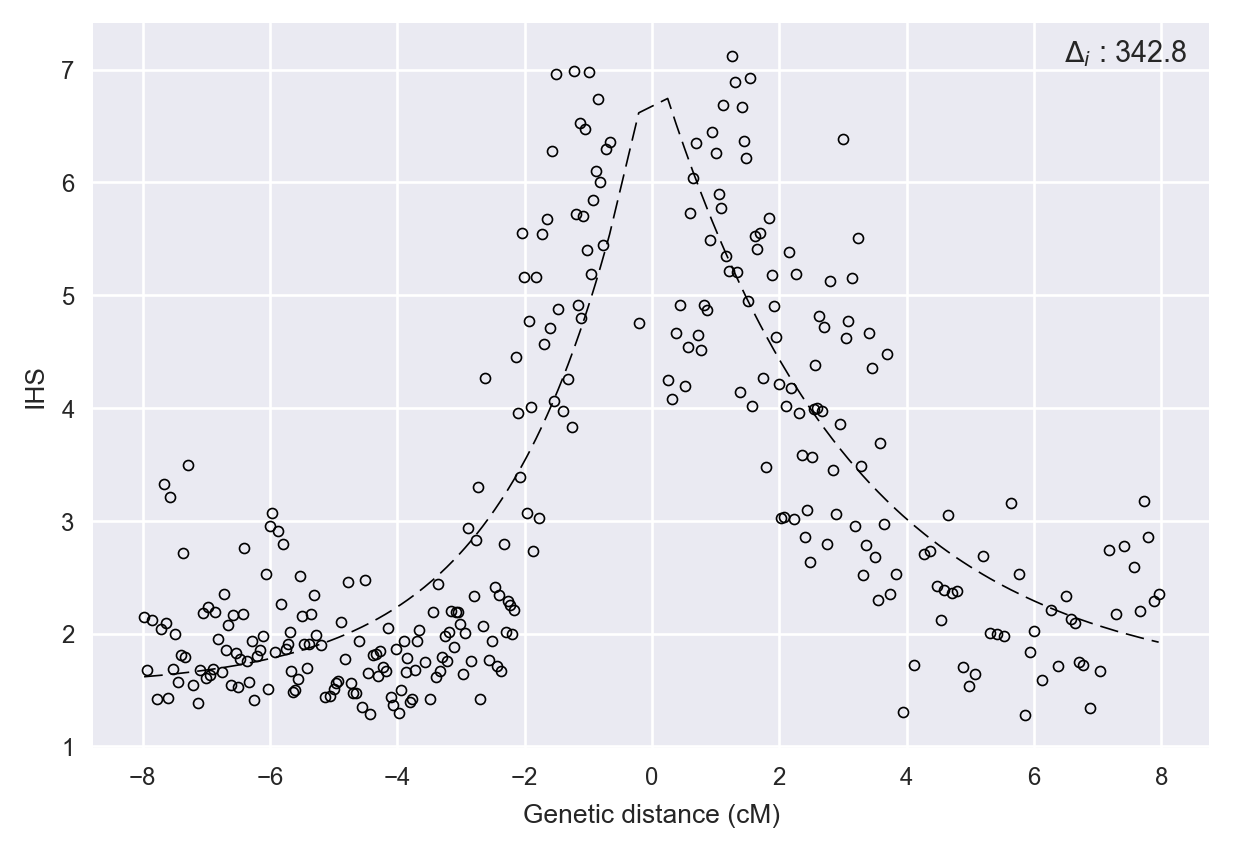

In [19]:
plot_ihs_peak_fit(pop='BFS', chromosome='X', center=cyp9k1_center, flank=8, fitter=ihs_skewed_exp_fitter)

## XPEHH

In [20]:
xpehh_raw = phase1_selection.xpehh_raw
xpehh_raw

Group(/, 5)
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [21]:
def build_xpehh_dataframe(focal_pop, ref_pop, seqid, window_size):

    xpehh_raw = phase1_selection.xpehh_raw
    if focal_pop == 'CMS':
        focal_pop = 'CMS_savanna'
    if ref_pop == 'CMS':
        ref_pop = 'CMS_savanna'

    if seqid is None:
        df = pd.concat([build_xpehh_dataframe(focal_pop, ref_pop, seqid=seqid, window_size=window_size)
                        for seqid in seqids])
        return df

    # extract raw values
    pop1, pop2 = focal_pop, ref_pop
    comparison = '%svs%s' % (pop1, pop2)
    flipped = False
    if comparison not in xpehh_raw[seqid]:
        flipped = True
    if flipped:
        pop1, pop2 = pop2, pop1
        comparison = '%svs%s' % (pop1, pop2)
    grp = xpehh_raw[seqid][comparison]
    pos = grp['POS'][:]
    values = grp['XPEHH_zscore'][:]
    if flipped:
        values = -values
    nomiss = ~np.isnan(values) & (values > 0)
    pos_nomiss = pos[nomiss]
    values_nomiss = values[nomiss]

    # construct moving windows
    starts_col = allel.moving_statistic(pos_nomiss, statistic=lambda v: v[0], size=window_size)
    starts_col[0] = 1  # fix to start of sequence
    ends_col = np.append(starts_col[1:] - 1, [len(genome[seqid])])

    # summarise values in windows
    values_col = allel.moving_statistic(values_nomiss, statistic=np.max, size=window_size)

    # seqid column
    seqid_col = np.array([seqid] * len(starts_col))

    # build dataframe
    df = pd.DataFrame.from_items([
        ('seqid', seqid_col),
        ('start', starts_col),
        ('end', ends_col),
        ('value', values_col)
    ])
    return df


In [22]:
# these are the regression model parameters
amplitude = lmfit.Parameter(value=3, vary=True, min=0)
decay = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # exponential
sigma = lmfit.Parameter(value=.5, vary=True, min=0.15, max=3)  # gaussian
skew = lmfit.Parameter(value=0, vary=True, min=-1, max=1)
baseline = lmfit.Parameter(value=1, vary=True, min=0, max=100)
ceiling = lmfit.Parameter(value=100, vary=False)
floor = lmfit.Parameter(value=0, vary=False)
null = lmfit.Parameter(value=1, vary=True, min=0, max=100)


# this determines how the full boundaries of the peak are found after the regression model has been fitted
peak_limit_frc = .2


xpehh_skewed_exp_fitter = peakfit.SkewedExponentialPeakFitter(
    amplitude=amplitude,
    decay=decay,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)


xpehh_skewed_gauss_fitter = peakfit.SkewedGaussianPeakFitter(
    amplitude=amplitude,
    sigma=sigma,
    skew=skew,
    baseline=baseline,
    ceiling=ceiling,
    floor=floor,
    null=null,
    peak_limit_frc=peak_limit_frc,
)

In [23]:
def plot_xpehh_peak_fit(focal_pop, ref_pop, chromosome, center, flank, fitter, ax=None, 
                        xlabel='Genetic distance (cM)', ylabel='XPEHH', window_size=800):

    df_xpehh = build_xpehh_dataframe(focal_pop, ref_pop, seqid=None, window_size=window_size)
    
    # This function handles concatenating data from multiple chromosome arms.
    # N.B., ignore percentiles for now, these are percentiles over windowed values.
    if chromosome == '2':
        seqid = '2R', '2L'
    elif chromosome == '3':
        seqid = '3R', '3L'
    else:
        seqid = chromosome
    starts, ends, values, percentiles = peakfit.extract_windowed_values(
        df_xpehh, seqid=seqid, genome=genome, values_col='value', seqid_col='seqid',
        starts_col='start', ends_col='end'
    )

    # setup X and Y coordinates
    x = ((starts + ends) / 2).astype(int)
    # this converts physical to genetic distance, needed if center and flank are also
    # given in terms of genetic distance
    x = gmap[chromosome].take(x - 1)
    y = values
    
    # fit the model
    fit = fitter.fit(x, y, center, flank)
    
    # plot
    if ax is None:
        fig, ax = plt.subplots()
    plot_opts = dict(marker='o', linestyle=' ', markersize=3, mfc='none', color='k', mew=.5)
    # plot the best fit line
    ax.plot(fit.xx, fit.best_fit, lw=.5, linestyle='--', color='k')
    # plot the data
    ax.plot(fit.xx, fit.yy, **plot_opts)
    # annotate
    ax.text(.98, .98, r'$\Delta_{i}$ : %.1f' % fit.delta_aic, transform=ax.transAxes, ha='right', va='top')
    # tidy
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # TODO add secondary yticklabels to right-hand Y axis with percentiles


/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


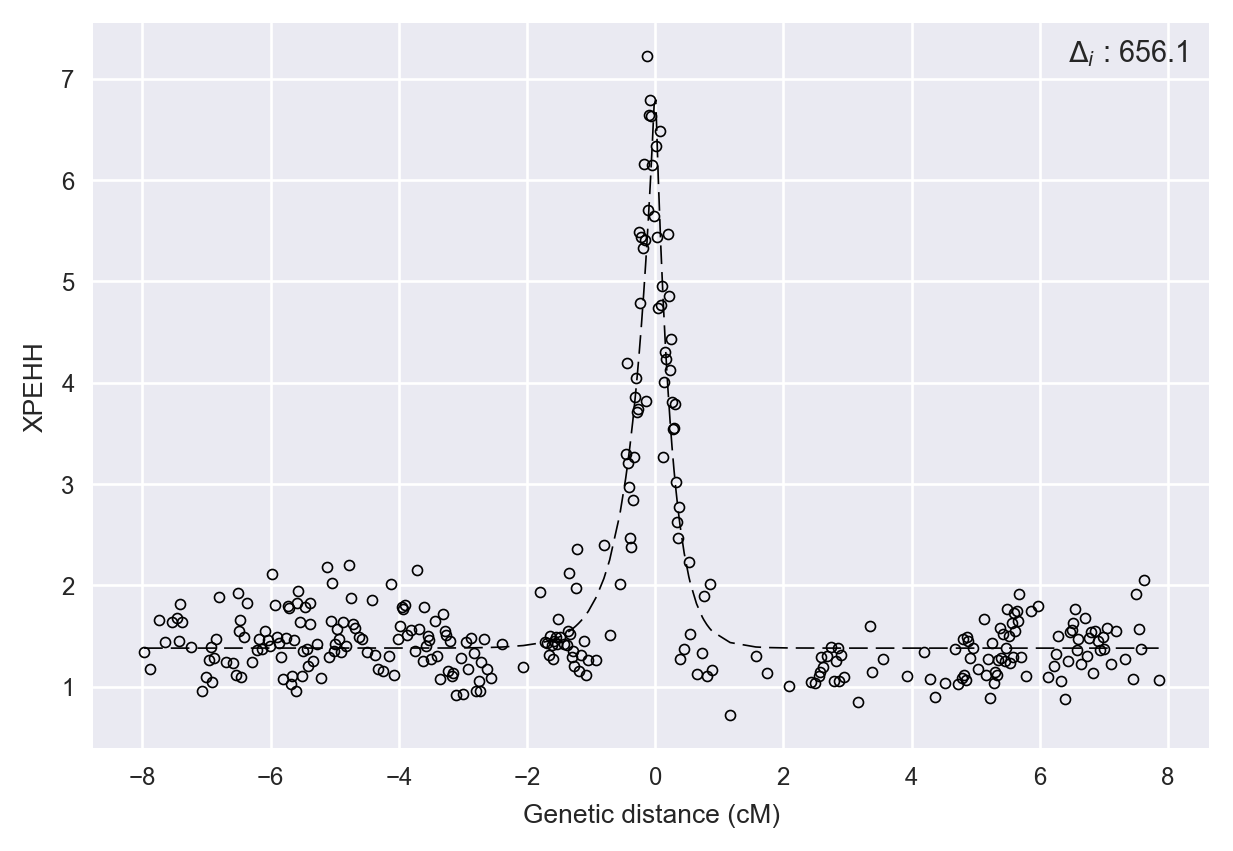

In [24]:
plot_xpehh_peak_fit(focal_pop='BFS', ref_pop='GWA', chromosome='2', center=cyp6p_center, flank=8, fitter=xpehh_skewed_exp_fitter)

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


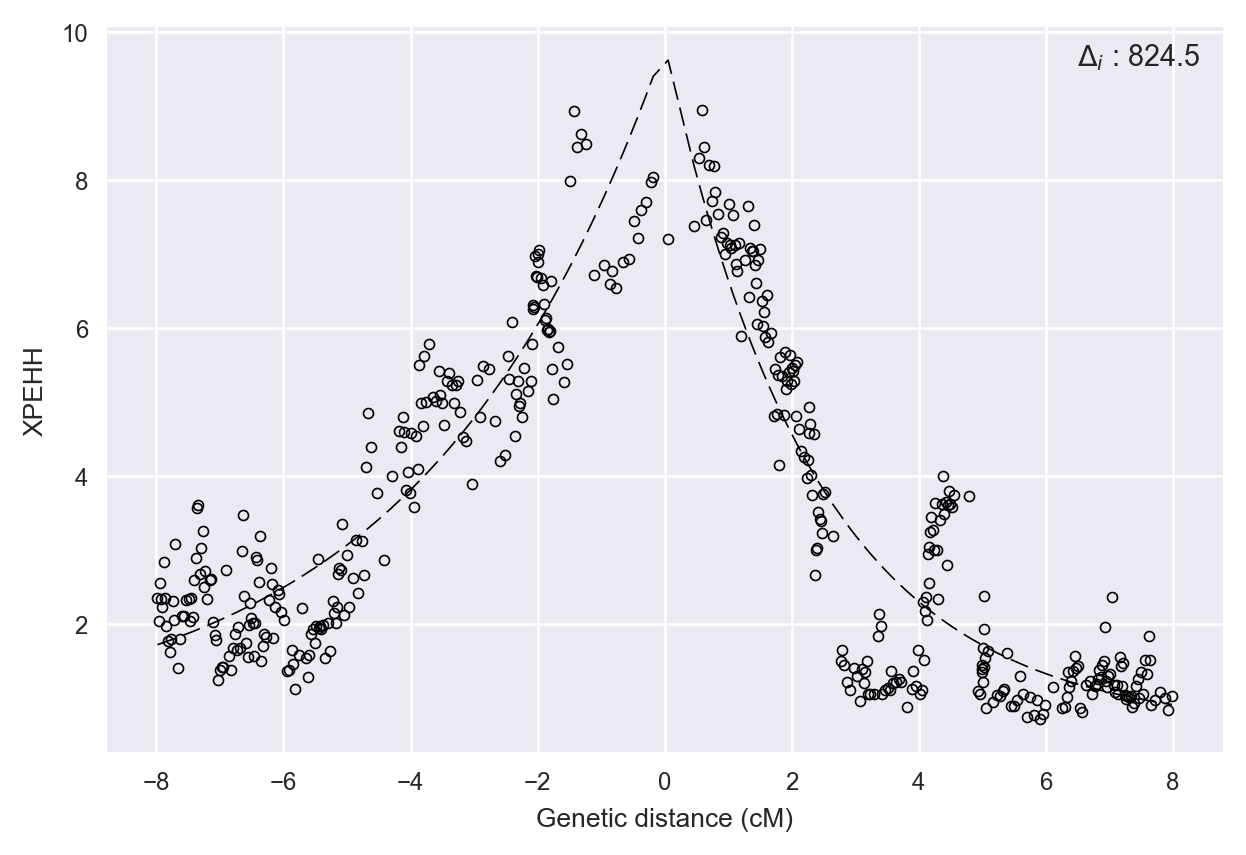

In [25]:
plot_xpehh_peak_fit(focal_pop='BFS', ref_pop='GWA', chromosome='2', center=vgsc_center, flank=8, fitter=xpehh_skewed_exp_fitter)

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


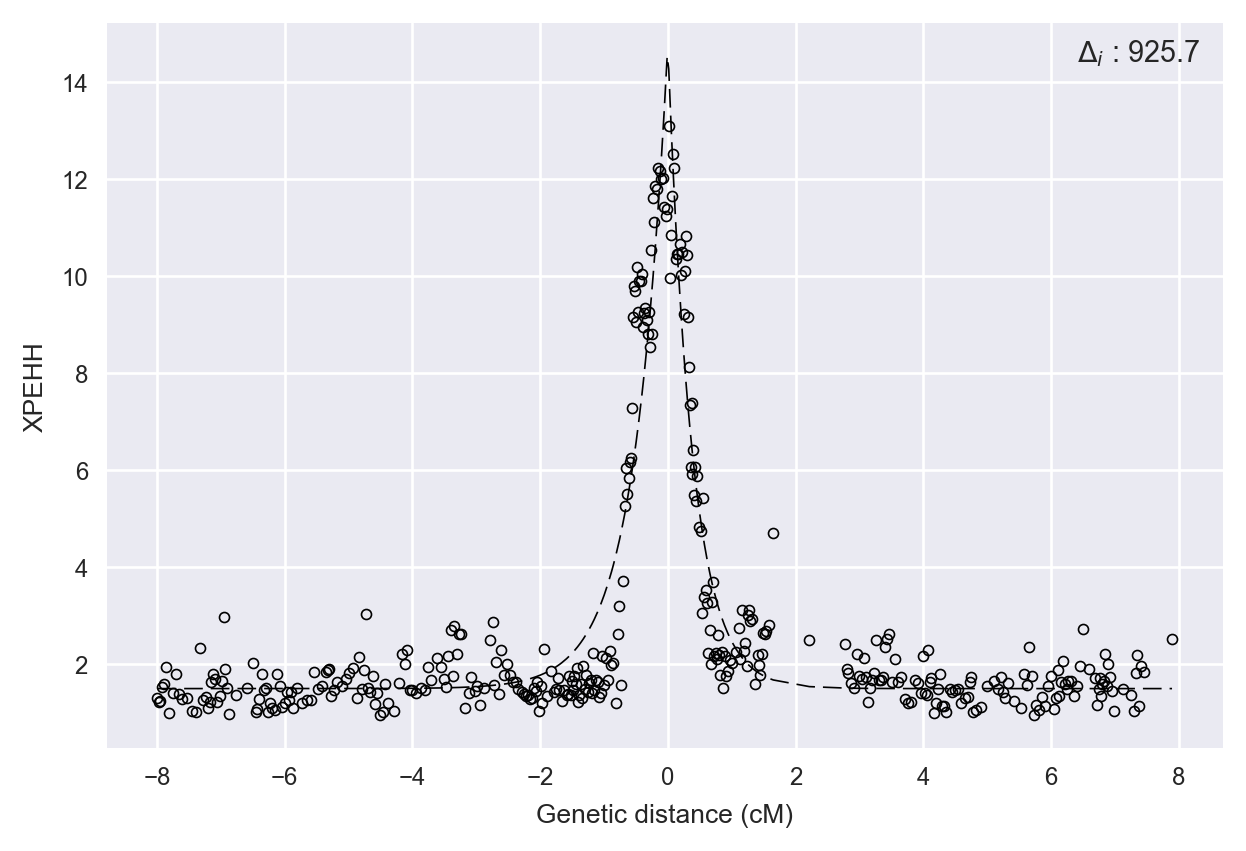

In [26]:
plot_xpehh_peak_fit(focal_pop='BFS', ref_pop='GWA', chromosome='3', center=gste_center, flank=8, fitter=xpehh_skewed_exp_fitter)

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


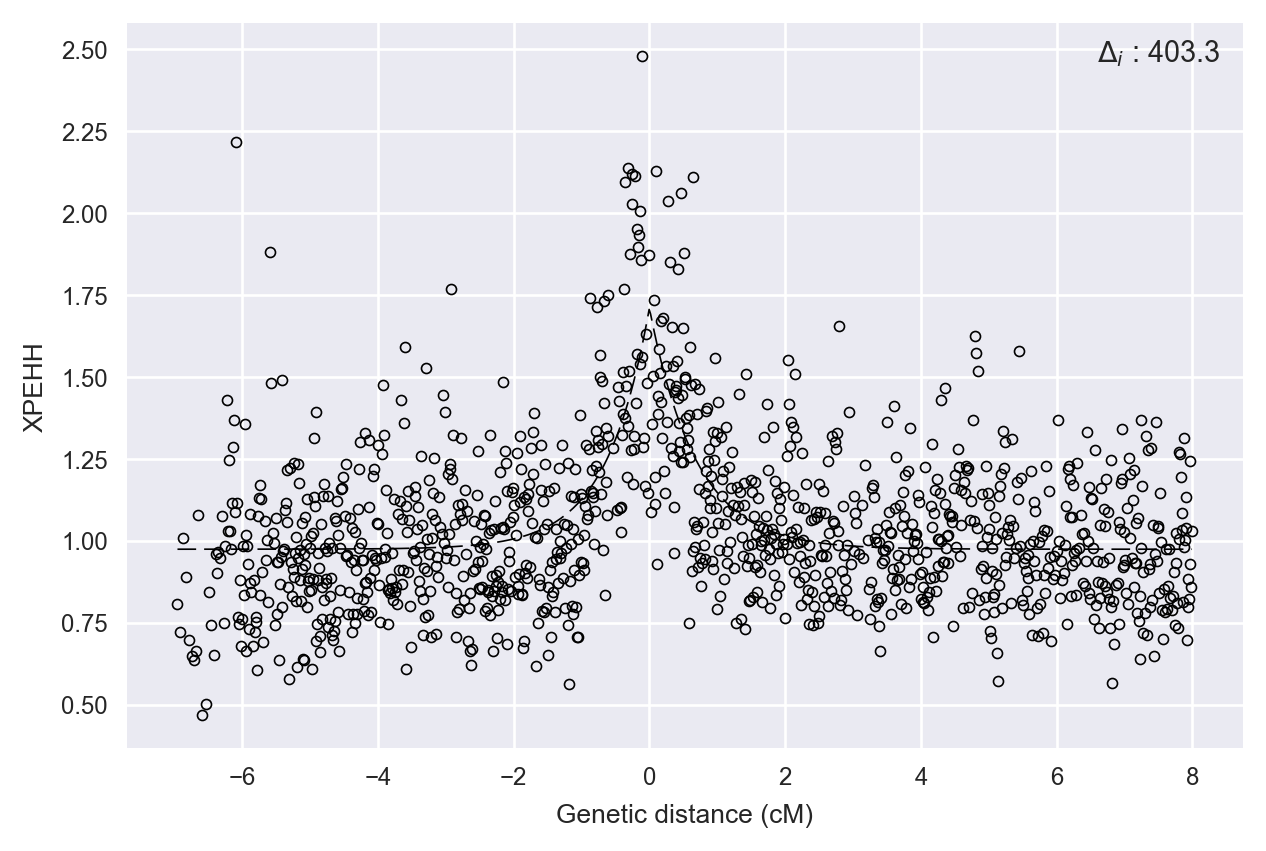

In [27]:
plot_xpehh_peak_fit(focal_pop='BFS', ref_pop='UGS', chromosome='2', center=ace1_center, flank=8, fitter=xpehh_skewed_exp_fitter)

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


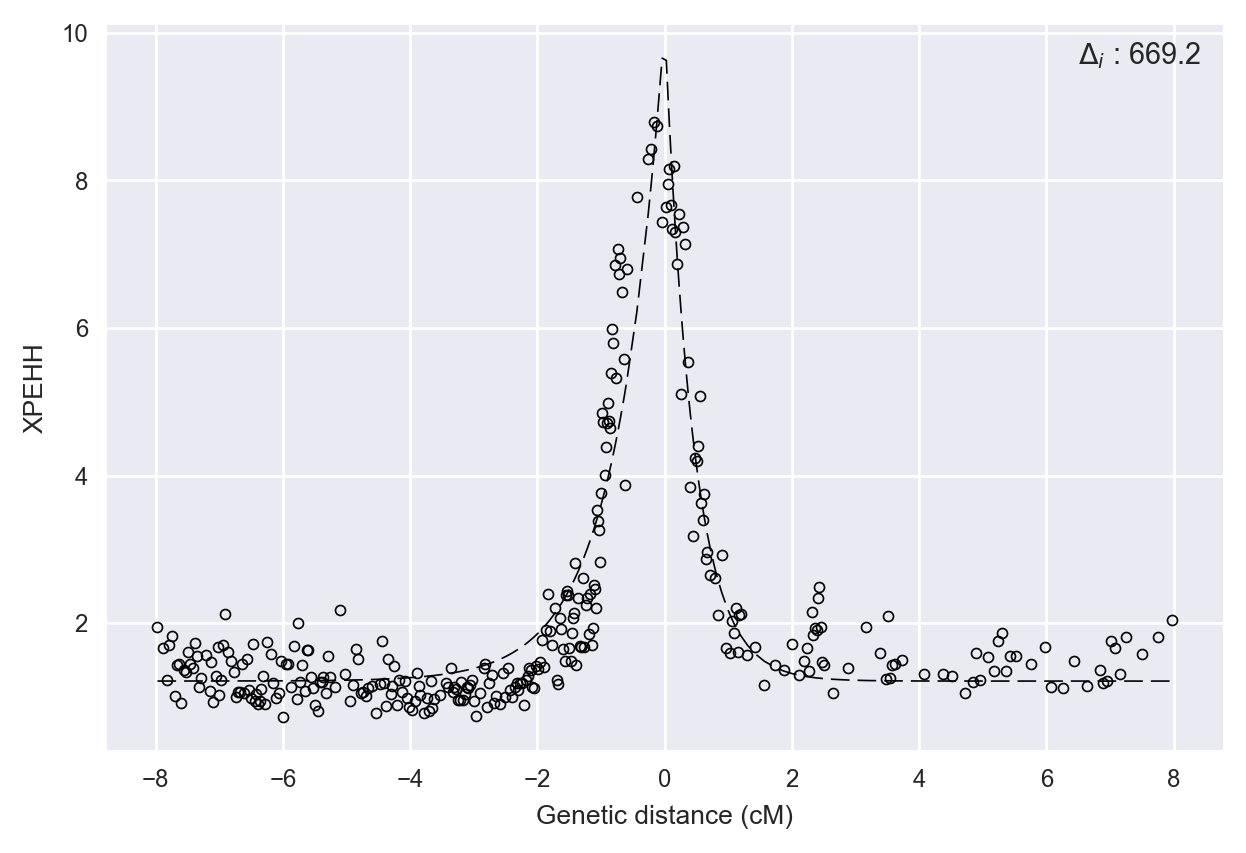

In [28]:
plot_xpehh_peak_fit(focal_pop='BFS', ref_pop='GWA', chromosome='X', center=cyp9k1_center, flank=8, fitter=xpehh_skewed_exp_fitter)